<a href="https://colab.research.google.com/github/Glasiermedic/Massachusetts-Schools/blob/master/Mass_Schooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Massachusetts School System
## Analysis prediction

### Data Exploration
#### I am very interested in identifying the current contributing factors for graduation rates, college admission test scores and 4 yr. college attendance rates in Massachusetts schools.  In this project I will first identity any trends or notable statistics around the variables. 

### Data cleaning and preparation
#### I will filter out features that add no value to the prediction like the school name, street address and city name.  I will also address any features that contain missing or placeholder data.  I will fit the data to a scale allowing the models to be more effective, utlize a correlation matrix and a random forest algorithm to determine the feature importance and if needed use Boruta to refine our features down to a managable and efficient set.  

### Modeling and model validation. 
#### As a part of the project I will define our exact question we will answer, identify the metric we will measure and create a model for predicting the outcome of our metric.  

##### Data used for this project came from the repository on Kaggle posted by [Nigel Dalziel](https://www.kaggle.com/ndalziel/massachusetts-public-schools-data#MA_Public_Schools_2017.csv).  Data compiled from [Massachusetts Department of Education ]http://profiles.doe.mass.edu/state_report/)

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
!pip3 install seaborn==0.9.0

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('white')


### Importing the data from Massachusetts Public Schools 2017

#### included a parameter to recognize a number written as "1,234" and store it as 1234 rather than the text object. 

In [0]:
#importing the data from CSV file
mass_ed = pd.read_csv("https://raw.githubusercontent.com/Glasiermedic/Massachusetts-Schools/master/MA_Public_Schools_2017.csv", thousands = ",")

#### The raw data from Massachusetts Schools includes the data for 1,861 schools.  They collected data over 302 different variables inlcuding the name of the school the school code and the physical location.  

In [0]:
#inspecting the dataframe for shape and content
mass_ed?

#### The school type variable could provided additional insight but is first needs converted  into a numerical categorical variable. 

In [0]:
# converint school type into a categorical variable usable by algorithms. 
for i in range(0,len(mass_ed['School Type'])):
  if (mass_ed['School Type'][i]) == 'Public School':
    mass_ed.at[i,'School Type']= 0
  else: 
    mass_ed.at[i,'School Type']= 1


#### Our newly converted variable reveals a majority of the schools in the dataset are public with less than ten percent reported as private. 

In [5]:
# counting how many are public versus private and other alternatives. 
mass_ed['School Type'].value_counts()

0    1778
1      83
Name: School Type, dtype: int64

#### Examining the names of the variables shows they utilize spaces, special characters, capitalizations and numerical notations.  A transformation of the variables will fix the issues so it is easier to perform preprocessing steps and utilization in the models. 


In [0]:
#creating a function to replace and remove unwanted characters and spaces.
def multiple_replacer(*key_values):
    replace_dict = dict(key_values)
    replacement_function = lambda match: replace_dict[match.group(0)]
    pattern = re.compile("|".join([re.escape(k) for k, v in key_values]), re.M)
    return lambda string: pattern.sub(replacement_function, string)

def multiple_replace(string, *key_values):
    return multiple_replacer(*key_values)(string)
  
  
replacements = (' ','_'), ('%', 'percent'), ('#', 'num'), ('(1-99)', "")
#Example:  multiple_replace("Sales % with #people", *replacements))

In [0]:
# using our function above to standardize and simplify the names of our variables
# including converting them to lowercase. 
ed_col = []
ed_columns =[]
for col in mass_ed.columns:
  ed_col.append(multiple_replace(col, *replacements))
for item in ed_col:
  ed_columns.append(item.lower())
#print(ed_columns) 

In [0]:
# applying the new column labels to the data. 
mass_ed.columns = ed_columns

In [0]:
# replacing all the missing/empty entries with zero to allow some of the
# algorithms to function correctly. 
mass_ed = mass_ed.replace(np.NAN, 0)

### Cleaning up the variables for feature selection

#### Some of the variables are the name and contact information for each school and their school code, these are all categorical in nature..    The School code was removed because it is a redundant indexing of data.  Many models will not except text and/or categorical data so the following variables have been removed for those reasons:

'function',  'contact_name',  'address_1',  'address_2',  'town', 'state',  'zip', 'phone',  'fax', 'grade',  'district_name',  'district_code'

In [0]:
# removing the contact information and school code for each school to allow for 
# our preliminary model(s) to function. 
mass_ed = mass_ed.drop([
    'school_code', 'function', 'contact_name', 'address_1', 'address_2', 'town',\
    'state', 'zip', 'phone', 'fax', 'grade', 'district_name', 'district_code'], axis = 1)

####  In Massachusetts middle school/junior high is not a set grade range.  We also have many charter and private schools represent a variety of grade ranges.  To address this issue we have divided the schools into five categories. K-12, [0], Elementary through 6th grade and special programs [1], middle/junior [2], 9th-12th [3], preschool/K [4]

In [11]:
# To help identify schools by their type we have created a numerical categorical
# variable which we will use to sort/filter the data.  
%%time 

def data_preprocess(x):
  if (x['1_enrollment'] > 1) and (x['11_enrollment']> 1) and (x['6_enrollment'] > 1):
    x['school_type'] = 0
  if (x['pk_enrollment'] > 1) and (x['1_enrollment'] < 1):
    x['school_type'] = 4  
  elif (x['9_enrollment'] +  x['10_enrollment'] +  x['11_enrollment'] +  x['12_enrollment']) > 1:
    x['school_type'] = 3
  elif (x['7_enrollment'] > 1):
    x['school_type'] = 2
  else:
    x['school_type'] = 1
  
  return x
  
  

#mass_ed_copy.apply(lambda x: x['1_enrollment'], axis=1)
mass_ed = mass_ed.apply(lambda x: data_preprocess(x), axis=1)

CPU times: user 606 ms, sys: 20.3 ms, total: 626 ms
Wall time: 626 ms


In [12]:
mass_ed.school_type.value_counts()

1    979
2    406
3    386
4     90
Name: school_type, dtype: int64

In [13]:
#filtering for all the schools that are high schools or K-12 schools for inclusion in the model. 

mass_ed_high = mass_ed.loc[mass_ed['school_type']==3]
mass_ed_high.add(mass_ed.loc[mass_ed['school_type']==0])
mass_ed_high.describe()

,school_type,pk_enrollment,k_enrollment,1_enrollment,2_enrollment,3_enrollment,4_enrollment,5_enrollment,6_enrollment,7_enrollment,...,percent_mcas_10thgrade_english_w/f,mcas_10thgrade_english_stud._incl._num,mcas_10thgrade_english_cpi,mcas_10thgrade_english_sgp,mcas_10thgrade_english_incl._in_sgp(num),school_accountability_percentile_,progress_and_performance_index_(ppi)_-_all_students,progress_and_performance_index_(ppi)_-_high_needs_students,district_progress_and_performance_index_(ppi)_-_all_students,district_progress_and_performance_index_(ppi)_-_high_needs_students
count,386.0,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,...,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.00000
mean,3.0,0.207254,3.284974,3.443005,3.279793,3.243523,3.266839,5.813472,11.238342,19.733161,...,2.093264,162.007772,84.419430,41.791451,142.455959,42.800518,62.932642,54.668394,63.303109,59.15285
std,0.0,2.943370,18.244277,18.774067,18.416381,18.425780,18.326300,26.261946,34.546865,46.309224,...,3.997610,139.683678,32.499896,22.092660,122.546909,32.272848,30.528090,32.072303,17.752961,15.93982
min,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,55.500000,93.300000,35.125000,45.250000,11.250000,58.000000,47.000000,53.000000,54.00000
50%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,120.500000,97.800000,46.750000,111.500000,42.000000,71.000000,65.000000,63.000000,57.00000
75%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,260.250000,99.200000,56.750000,221.500000,71.000000,83.000000,76.000000,72.750000,68.00000
max,3.0,54.000000,178.000000,182.000000,183.000000,191.000000,191.000000,244.000000,242.000000,386.000000,...,44.000000,925.000000,100.000000,88.000000,757.000000,99.000000,100.000000,100.000000,100.000000,100.00000


###  Investigating the precentage of students who go on to attend college. 

#### There appears to be a percentage of schools that are reporting 0% which has shifted the average and standard deviation.  Upon evaluating the specific school reporting none of their students have gone on to college it was determined they are special programs and they have been filtered out. 

#### There are 328 schools with a range of 10% to 100% going on to attend college.  The average for the schools is 74.3% with a majority of the schools falling into the 58% to 90% range.  

In [14]:

print (mass_ed_high['percent_attending_college'].describe())

count    386.000000
mean      63.158808
std       30.580845
min        0.000000
25%       54.625000
50%       75.500000
75%       85.700000
max      100.000000
Name: percent_attending_college, dtype: float64


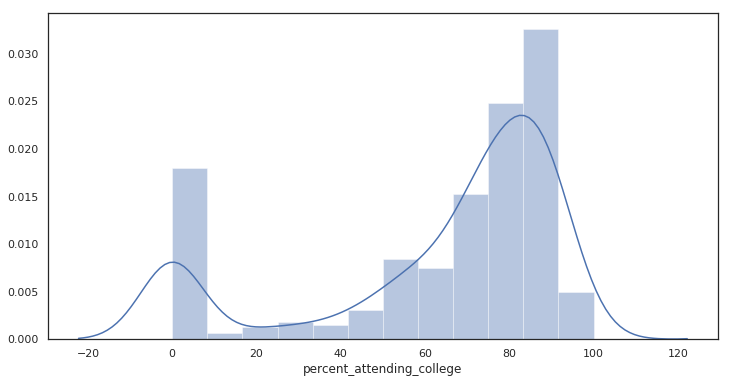

In [15]:
plt.figure(figsize=(12, 6))
sns.distplot(mass_ed_high['percent_attending_college'])

plt.savefig('prec.png')

In [16]:
mass_ed_no_grad = mass_ed_high[mass_ed_high.percent_attending_college == 0]

mass_ed_no_grad.shape

(58, 289)

#### After examining the schools reporting 0% college attendance  

In [0]:
#mass_ed_high = mass_ed_high[mass_ed_high.percent_attending_college != 0]

In [18]:
print (mass_ed_high['percent_attending_college'].describe())

count    386.000000
mean      63.158808
std       30.580845
min        0.000000
25%       54.625000
50%       75.500000
75%       85.700000
max      100.000000
Name: percent_attending_college, dtype: float64


In [19]:

print ("most frequent precentage of college attendance: \n{} \
       \n".format(mass_ed_high['percent_attending_college'].value_counts().head(10)))

print ("less frequent precentage of college attendance: \n{} \
       \n".format(mass_ed_high['percent_attending_college'].value_counts().tail(10)))

most frequent precentage of college attendance: 
0.0     58
87.5     5
89.5     4
89.3     4
71.4     4
87.7     4
89.9     4
90.7     3
84.1     3
84.6     3
Name: percent_attending_college, dtype: int64        

less frequent precentage of college attendance: 
62.7    1
51.9    1
28.6    1
91.7    1
31.2    1
46.6    1
80.8    1
58.6    1
72.9    1
69.3    1
Name: percent_attending_college, dtype: int64        



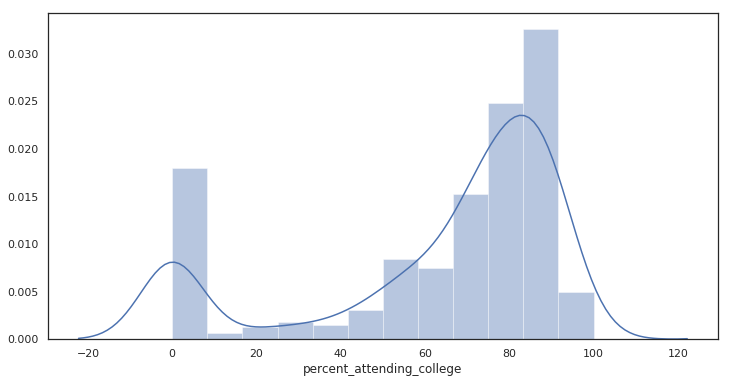

In [20]:
plt.figure(figsize=(12, 6))
sns.distplot(mass_ed_high['percent_attending_college'])

plt.savefig('prec.png')

### Selecting Features

#### For the purposes of this project we are looking at factors that we use to predict the college attendance of students.  Variables that relate to graduating high school and post high school aternatives have been excluded from the possible feature list.  Including gender, socio-economic and ethnical variables was also considered.  It was determined that including gender, ethic data and thee economic-status with the understanding that we are not intending to shift the percentages to improve a schools college attendance outcomes, rather to hightlight that a need for further investigation maybe needed.  

In [0]:
# This cell allows for the exclusion of gender, economic status and ethnicity. 

#mass_ed_high.drop(['economically_disadvantaged',
#       'percent_economically_disadvantaged', 'percent_african_american',
#      'percent_asian', 'percent_hispanic', 'percent_white',
#       'percent_native_american', 'percent_native_hawaiian,_pacific_islander',
#       'percent_multi-race,_non-hispanic', 'percent_males', 'percent_females'])

In [22]:
X = mass_ed_high.drop(['high_school_graduates_(num)', 'percent_umass', 'percent_private_two-year', 'percent_public_two-year', 'percent_ma_community_college', 'percent_private_four-year', 'percent_mcas_10thgrade_english_a', 'percent_ma_state_university', 'attending_coll./univ._(num)', 'percent_public_four-year', 'percent_attending_college', 'school_name', 'high_needs', 'economically_disadvantaged', 'percent_mcas_10thgrade_english_p+a', 'accountability_and_assistance_level', 'accountability_and_assistance_description', 'progress_and_performance_index_(ppi)_-_all_students', 'progress_and_performance_index_(ppi)_-_high_needs_students', 'district_accountability_and_assistance_level', 'district_accountability_and_assistance_description', 'district_progress_and_performance_index_(ppi)_-_all_students', 'district_progress_and_performance_index_(ppi)_-_high_needs_students'],axis =1)
#X = mass_ed_high.drop(['percent_attending_college'],axis =1)

y = mass_ed_high['percent_attending_college'] 
print(y.shape)
print (X.shape)

(386,)
(386, 266)


#### The data needs to be scaled for some of the machine learning models.  In most instances the performance of the models improves with scaling.  

In [0]:
scaler = StandardScaler()


from sklearn.model_selection import KFold
kfolds = KFold(n_splits =5, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



In [0]:
forest = RandomForestRegressor(max_depth=7,n_jobs=-1, random_state=1, n_estimators=100, verbose=0)




In [25]:
pipe_forest = Pipeline([('scaler', StandardScaler()), ('model', forest)])
pipe_forest.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False))])

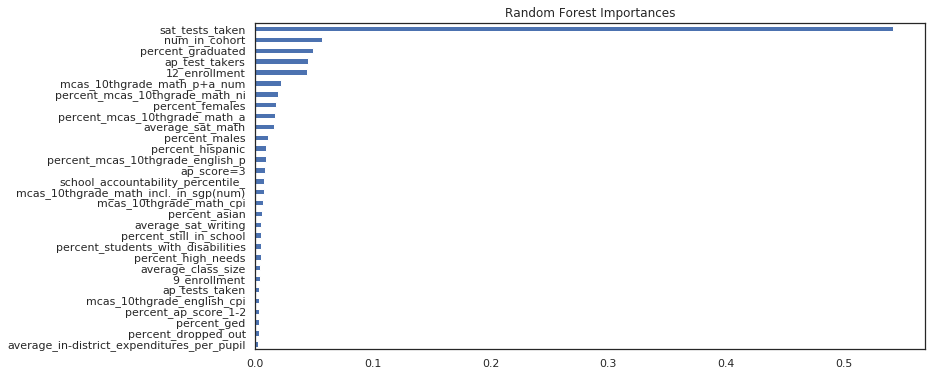

In [26]:
importances_for = forest.feature_importances_

indices = np.argsort(importances_for)[::-1]
for_imp_feat = []

for f in range(X.shape[1]):
    for_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(importances_for, index=X.columns)
importances_df.nlargest(30).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("Random Forest Importances")
plt.show()

In [0]:
import xgboost as xgb
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', 
                          learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
  nthread=4,
 scale_pos_weight=1, scoring='neg_mean_squared_error', random_state =1)

In [28]:
pipe_xgb = Pipeline([('scaler', StandardScaler()), ('model', xg_reg_lin)])
pipe_xgb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1,...cale_pos_weight=1, scoring='neg_mean_squared_error',
       seed=None, silent=True, subsample=0.8))])

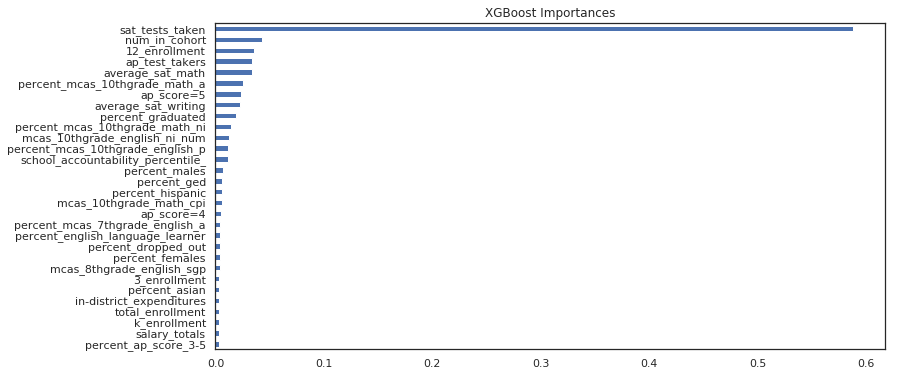

In [29]:
importances_xgb = xg_reg_lin.feature_importances_

indices = np.argsort(importances_xgb)[::-1]
xgb_imp_feat = []

for f in range(X.shape[1]):
    xgb_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(importances_xgb, index=X.columns)
importances_df.nlargest(30).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("XGBoost Importances")
plt.show()


In [0]:


#print(pipe_xgb.score(X_test,y_test))

In [0]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)


In [32]:
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('model', lasso)])
pipe_lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

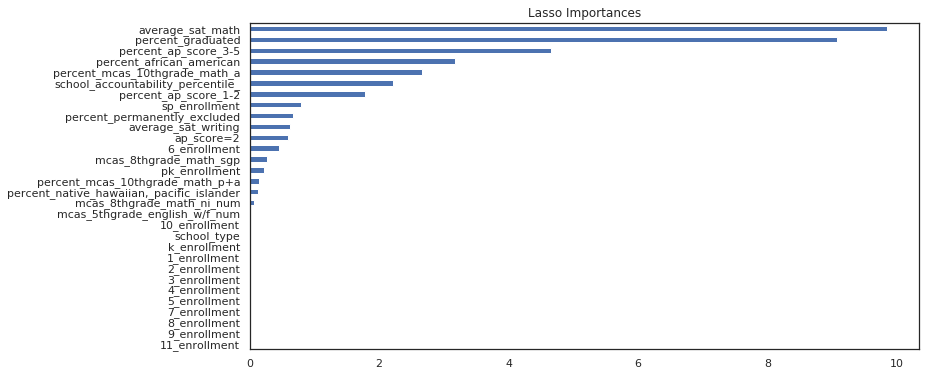

In [33]:
indices = np.argsort(lasso.coef_)[::-1]
lasso_imp_feat = []

for f in range(X.shape[1]):
    lasso_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(lasso.coef_, index=X.columns)
importances_df.nlargest(30).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("Lasso Importances")

plt.show()

In [34]:
lasso_imp_feat[:35]

['average_sat_math',
 'percent_graduated',
 'percent_ap_score_3-5',
 'percent_african_american',
 'percent_mcas_10thgrade_math_a',
 'school_accountability_percentile_',
 'percent_ap_score_1-2',
 'sp_enrollment',
 'percent_permanently_excluded',
 'average_sat_writing',
 'ap_score=2',
 '6_enrollment',
 'mcas_8thgrade_math_sgp',
 'pk_enrollment',
 'percent_mcas_10thgrade_math_p+a',
 'percent_native_hawaiian,_pacific_islander',
 'mcas_8thgrade_math_ni_num',
 'mcas_5thgrade_english_w/f_num',
 'mcas_4thgrade_math_sgp',
 'percent_mcas_4thgrade_math_w/f',
 'percent_mcas_4thgrade_math_p',
 'percent_mcas_4thgrade_math_ni',
 'mcas_4thgrade_math_cpi',
 'mcas_4thgrade_math_stud._incl._num',
 'mcas_4thgrade_math_ni_num',
 'mcas_4thgrade_math_w/f_num',
 'mcas_4thgrade_math_p+a_num',
 'mcas_4thgrade_math_p_num',
 'percent_mcas_4thgrade_math_a',
 'mcas_4thgrade_math_a_num',
 'percent_mcas_4thgrade_math_p+a',
 'mcas_5thgrade_math_p+a_num',
 'mcas_3rdgrade_math_incl._in_sgp(num)',
 'mcas_3rdgrade_math_sg

In [35]:
# Function to find common elements in n arrays 
def commonElements(arr): 
	
	# initialize result with first array as a set 
	result = set(arr[0]) 

	# now iterate through list of arrays starting from 
	# second array and take intersection_update() of 
	# each array with result. Every operation will 
	# update value of result with common values in 
	# result set and intersected set 
	for currSet in arr[1:]: 
		result.intersection_update(currSet) 

	return list(result) 

 
arr = [lasso_imp_feat[:80], xgb_imp_feat[:80], for_imp_feat[:80]] 
output = commonElements(arr) 
if len(output) > 0: 
	print (len(output))
else: 
	print ('No Common Elements Found')


18


In [36]:
output 

['6_enrollment',
 'sp_enrollment',
 'percent_mcas_10thgrade_math_a',
 'percent_native_american',
 'percent_white',
 'school_accountability_percentile_',
 'percent_mcas_10thgrade_math_p+a',
 'average_sat_writing',
 'percent_ap_score_1-2',
 'sat_tests_taken',
 'first_language_not_english',
 'average_sat_math',
 'percent_native_hawaiian,_pacific_islander',
 'percent_ap_score_3-5',
 'percent_females',
 'percent_african_american',
 'percent_males',
 'percent_graduated']

In [37]:
X_for = X[list(for_imp_feat)[:16]]

X_xgb = X[list(xgb_imp_feat)[:16]]

X_lasso = X[list(lasso_imp_feat)[:16]]
X_lasso35 = X[list(lasso_imp_feat)[:35]]

X_out =X[list(output)]

feat_list = [X_for, X_xgb, X_lasso, X_lasso35, X_out]
print_list =['Random Forest', 'XGBoost', 'Lasso', 'Lasso_35', 'Combined']

X_out.shape


(386, 18)

### Lasso models 
#### Logic loop running through the four feature importance lists generated.  Grid search with cross validation is used to select the best parameters for the model.  


grid = GridSearchCV(pipe_knn, param_grid=grid_params, 
                    scoring='accuracy', cv=kfolds, 
                    return_train_score=True, verbose=1, n_jobs=-1)   model__n_neighbors'

In [38]:
%%time
alpha_list = [.012, .014, .015 , .018, .020, .022, .024, .025, .026, .27, .028, .3, .32, .1]
parameters = {'alpha': alpha_list,
                    'fit_intercept': [True,False], 
                    'normalize' :[True], 'max_iter':[40, 45, 50, 55, 60]}

for i in range (0,5):
  X_train, X_test, y_train, y_test = train_test_split(feat_list[i], y, random_state =1, test_size = 0.2)
  
  print ("------ " +print_list[i] + " -------")
  lasso_grid = GridSearchCV(lasso, parameters, cv=kfolds, scoring='neg_mean_squared_error')
  lasso_grid.fit(X_train,y_train)        
  print (lasso_grid.best_estimator_)
  print(np.sqrt(-lasso_grid.best_score_))
  
  y_pred_lasso = lasso_grid.predict(X_test)

------ Random Forest -------
Lasso(alpha=0.012, copy_X=True, fit_intercept=True, max_iter=40,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
15.137643352247213
------ XGBoost -------
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=50, normalize=True,
   positive=False, precompute=False, random_state=1, selection='cyclic',
   tol=0.0001, warm_start=False)
15.308491352867954
------ Lasso -------
Lasso(alpha=0.018, copy_X=True, fit_intercept=True, max_iter=40,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
14.109124845002558
------ Lasso_35 -------
Lasso(alpha=0.018, copy_X=True, fit_intercept=True, max_iter=40,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
14.08727802396186
------ Combined -------
Lasso(alpha=0.028, copy_X=True, fit_intercept=True, max_it

Random Forest

In [39]:
%%time
forest = RandomForestRegressor(max_depth=7,n_jobs=-1, random_state=1, n_estimators=100, verbose=0)


alpha_list = [.012, .014, .015 , .018, .020, .022, .024, .025, .026, .028, .1]
parametersr = {'max_depth': [ 16], 'n_estimators': [900]}

#for i in range (0,5):
X_train, X_test, y_train, y_test = train_test_split(X_lasso35, y, random_state =1, test_size = 0.2)
  
print ("------ Lasso Importance -------")
forest_grid = GridSearchCV(forest, parametersr, cv=kfolds, scoring='neg_mean_squared_error')
forest_grid.fit(X_train,y_train)
print (forest_grid.best_estimator_)
print(np.sqrt(-forest_grid.best_score_))
  
  
y_pred_forest = forest_grid.predict(X_test)

------ Lasso Importance -------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
15.080172387056406
CPU times: user 8.27 s, sys: 784 ms, total: 9.05 s
Wall time: 14.4 s


XGBoost

In [40]:
%%time
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', gamma=0, max_leaf_nodes=2,
                              subsample=0.8, colsample_bytree=0.8, nthread=4,
                              scale_pos_weight=1, random_state =1)

parametersg2 = {'gamma':[i/50.0 for i in range(6,10)], 'subsample':[i/10.0 for i in range(3,5)],
                'learning_rate': [.025], 'max_depth': [5], 'n_estimators': [250], 'min_child_weight':[8],
 'colsample_bytree':[i/10.0 for i in range(6,8)]}

#for i in range (0):
X_train, X_test, y_train, y_test = train_test_split(X_lasso35, y, random_state =1, test_size = 0.2)
  
print ("------ Lasso Importance -------")
xgb_grid = GridSearchCV(xg_reg_lin, parametersg2, cv=kfolds, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train,y_train)
print (xgb_grid.best_estimator_)
print(np.sqrt(-xgb_grid.best_score_))
  
#xgb_grid.fit(X,y)  
#y_pred_xgb = xgb_grid.predict(X)

------ Lasso Importance -------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.14, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=5,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=250, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.400253941732588
CPU times: user 26.1 s, sys: 5.74 s, total: 31.9 s
Wall time: 17.3 s


#### This section fine tunes the number of features for the XGBoost model.  The optimum number of features with the fine tuning of hyperparameters produces the best results at 35 features.  

In [41]:
%%time
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', gamma=0, max_leaf_nodes=2,
                              subsample=0.8, colsample_bytree=0.8, nthread=4,
                              scale_pos_weight=1, random_state =1)

parametersg2 = {'gamma':[i/50.0 for i in range(8,10)], 
                'subsample':[i/10.0 for i in range(4,5)],
                'learning_rate': [.025], 'max_depth': [4],
                'n_estimators': [225,250,275], 'min_child_weight':[8],
 'colsample_bytree':[i/10.0 for i in range(6,7)]}

feat_list2 = [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


for i in feat_list2:
#for i in range (0,51)
  X_train, X_test, y_train, y_test = train_test_split(X[list(lasso_imp_feat)[:i]], y, random_state =1, test_size = 0.2)
  
  print ("------ " + str(i) +" -------")
  xgb_grid = GridSearchCV(xg_reg_lin, parametersg2, cv=kfolds,
                          scoring='neg_mean_squared_error', verbose = 1)
  xgb_grid.fit(X_train,y_train)
  print (X_train.shape)
  print (xgb_grid.best_estimator_)
  print(np.sqrt(-xgb_grid.best_score_))

------ 25 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 25)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.26602730151493
------ 26 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 26)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.345465285147737
------ 27 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 27)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.3985136448502
------ 28 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 28)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.314460460665858
------ 29 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 29)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.39497569172917
------ 30 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 30)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.205201390656505
------ 31 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 31)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.283483726178991
------ 32 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 32)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.444024987099382
------ 33 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 33)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.58797350850233
------ 34 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(308, 34)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.580870412040651
------ 35 -------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(308, 35)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.16, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=4,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=225, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
14.325980

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.8s finished


In [0]:
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', 
                          learning_rate =0.025, gamma=0.16, 
 n_estimators=225,
 max_depth=4,
 min_child_weight=8, 
 subsample=0.4,
 colsample_bytree=0.6,
  nthread=4, max_leaf_nodes=2, 
 scale_pos_weight=1, scoring='neg_mean_squared_error', random_state =1)

X_train, X_test, y_train, y_test = train_test_split(X[list(lasso_imp_feat)[:35]],
                                                    y, random_state =1, test_size = 0.2)

In [43]:
#@title
pipe_xgb = Pipeline([('scaler', StandardScaler()), ('model', xg_reg_lin)])
pipe_xgb.fit(X_train, y_train)

print (pipe_xgb.score(X_test,y_test))

print("accurate to within: %{} for our training data ".format(np.sqrt(-xgb_grid.best_score_)))

0.8344694799867213
accurate to within: %14.325980231132123 for our training data 


In [44]:
#@title

pipe_final = Pipeline([('scaler', StandardScaler())])
pipe_final.fit(X_lasso35, y)



Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [45]:
#@title
#takes the average of the actual minus the predicted for the data entries.  

average_error =(y-pipe_xgb.predict(X_lasso35)).mean()

stand_dev =(y-pipe_xgb.predict(X_lasso35)).std()

print ("the average error using the XGBoost model is :%{}".format(average_error))

print ("the standard deviation using the XGBoost model is :%{}".format(stand_dev))

the average error using the XGBoost model is :%0.7477699388185319
the standard deviation using the XGBoost model is :%9.936547458197577


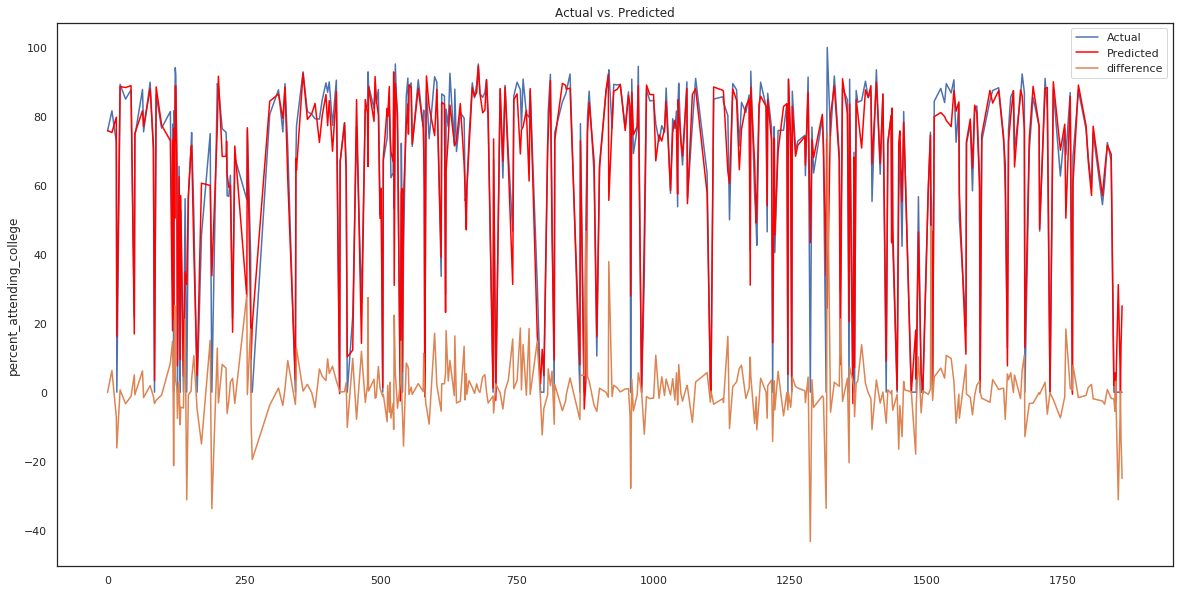

In [46]:

plt.figure(figsize=(20, 10))
sns.lineplot(x = X_lasso35.index, y = y, label ='Actual', )
sns.lineplot(x = X_lasso35.index, y = (pipe_xgb.predict(X_lasso35)), color ='red', label ='Predicted')
plt.title('Actual vs. Predicted')
plt.legend
sns.lineplot(x = X_lasso35.index, y = (y-(pipe_xgb.predict(X_lasso35))), label ='difference')
plt.show()

In [47]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5, leaf_size=30)


parameters = {'n_neighbors': [2, 3, 4, 5, 6], 'leaf_size': [10, 20, 30]}


feat_list2 = [1, 3, 5]

final = '24 features'
for i in feat_list2:
  X_train, X_test, y_train, y_test = train_test_split(X[list(lasso_imp_feat)[:i]], y, random_state =1, test_size = 0.2)
  
  print ("------ " + str(i) +" -------")
  knn_grid = GridSearchCV(neigh, parameters, cv=kfolds, scoring='neg_mean_squared_error')
  knn_grid.fit(X_train,y_train)
  print (knn_grid.best_estimator_)
  print(np.sqrt(-knn_grid.best_score_))

------ 1 -------
KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=6, p=2,
          weights='uniform')
16.91480618541174
------ 3 -------
KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=6, p=2,
          weights='uniform')
16.77059641278163
------ 5 -------
KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=6, p=2,
          weights='uniform')
15.811923551767078


In [48]:
from sklearn import linear_model
bayes = linear_model.BayesianRidge(normalize = True, compute_score= True, )

alpha_list = [1e-02, 1e-04, 1e-06]

parameters = {'n_iter': [1,2, 3,4, 5], 'alpha_1': alpha_list,
              'alpha_2': alpha_list, 'lambda_1': alpha_list,
              'lambda_2': alpha_list, 'tol': alpha_list}

feat_list2 = [13, 91]


#for i in feat_list2:
for i in range(1, 5, 2):
  X_train, X_test, y_train, y_test = train_test_split(X[list(lasso_imp_feat)[:i]], y, random_state =1, test_size = 0.2)
  
  print ("------ " + str(i) +" -------")
  bayes_grid = GridSearchCV(bayes, parameters, cv=kfolds,
                            scoring='neg_mean_squared_error', verbose = 1 )
  bayes_grid.fit(X_train,y_train)
  print (bayes_grid.best_estimator_)
  print(np.sqrt(-bayes_grid.best_score_))

------ 1 -------
Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6075 out of 6075 | elapsed:   30.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BayesianRidge(alpha_1=0.01, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=0.01, n_iter=5,
       normalize=True, tol=0.01, verbose=False)
16.923176201321205
------ 3 -------
Fitting 5 folds for each of 1215 candidates, totalling 6075 fits
BayesianRidge(alpha_1=1e-06, alpha_2=0.01, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=0.0001, lambda_2=1e-06, n_iter=3,
       normalize=True, tol=0.01, verbose=False)
15.25241042542426


[Parallel(n_jobs=1)]: Done 6075 out of 6075 | elapsed:   31.0s finished


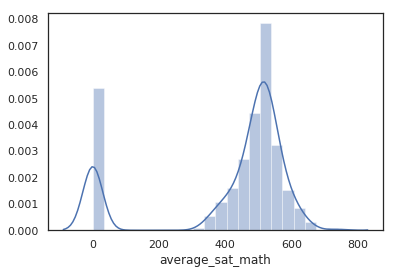

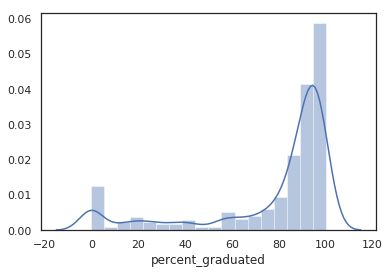

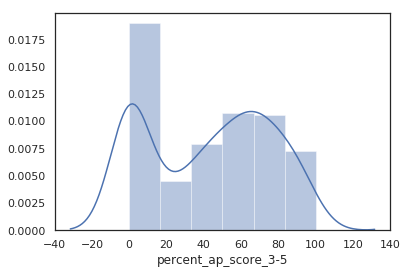

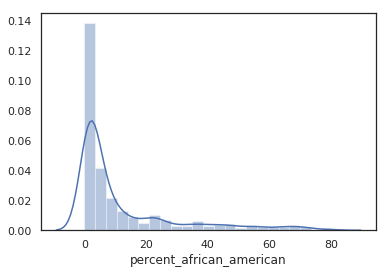

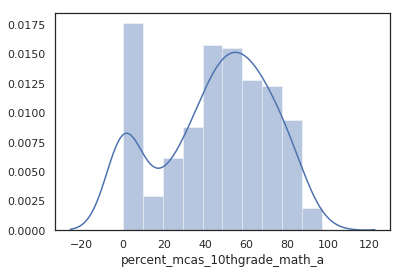

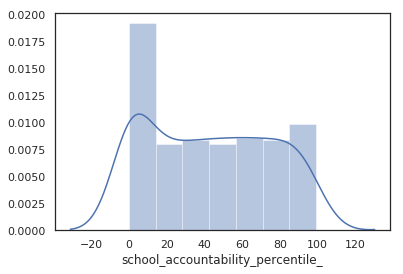

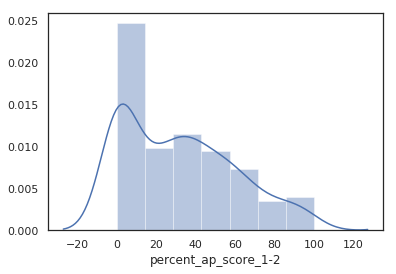

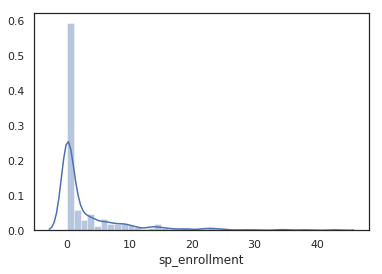

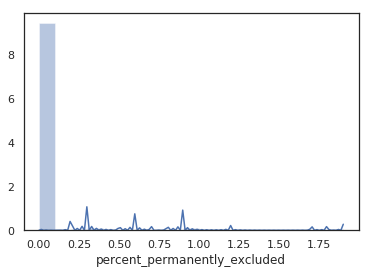

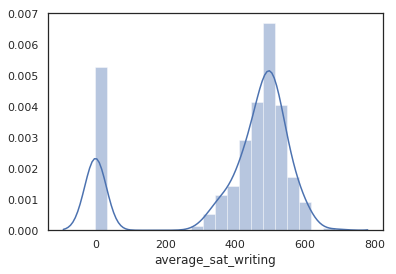

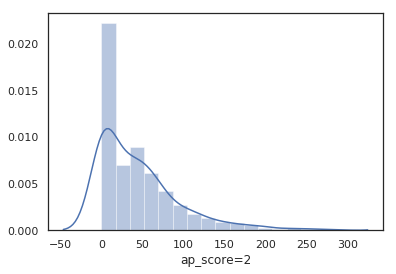

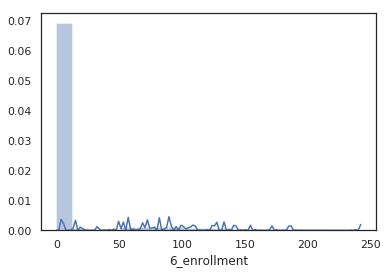

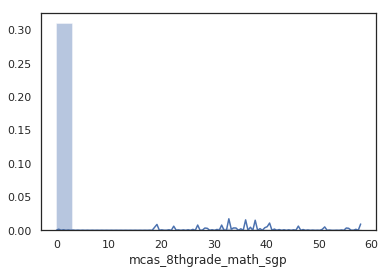

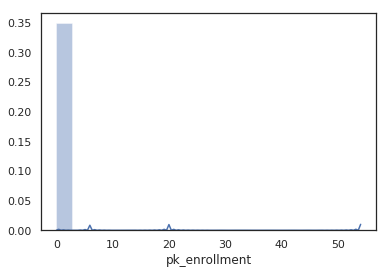

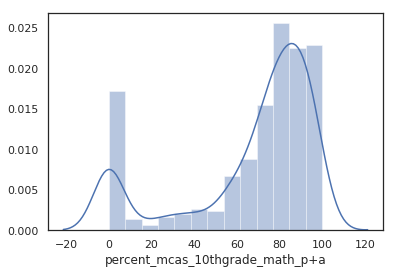

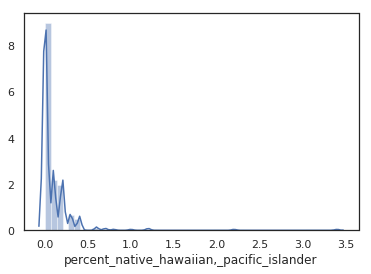

In [49]:
for col in X_lasso:
  sns_plot = sns.distplot(mass_ed_high[col], label = col)
  #plt.title(col)
  plt.show()
  
  

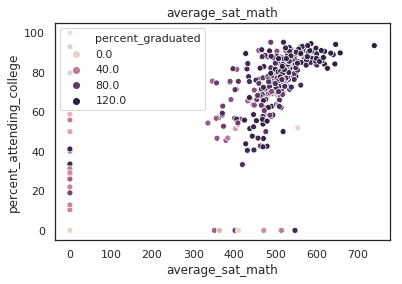

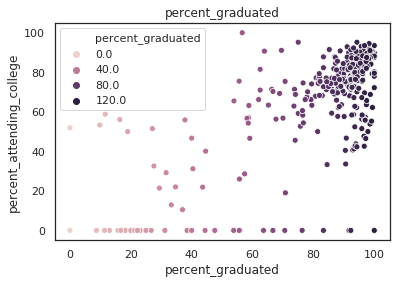

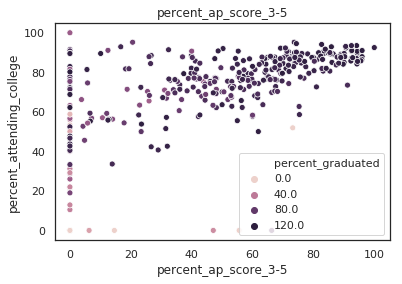

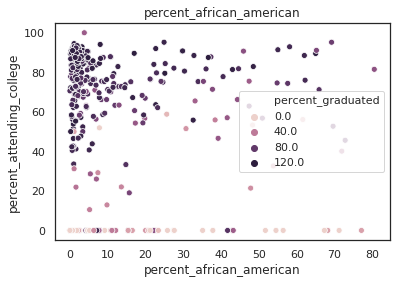

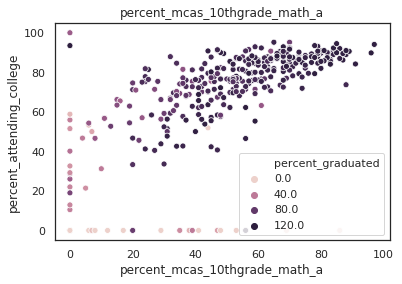

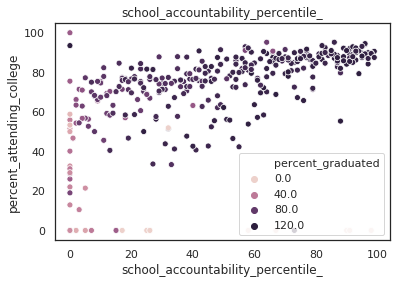

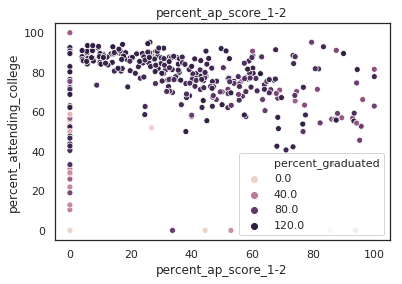

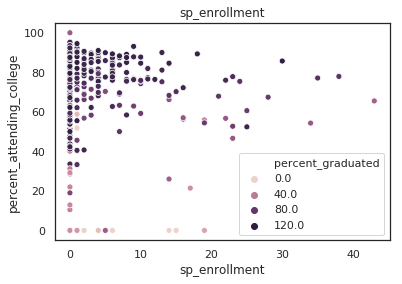

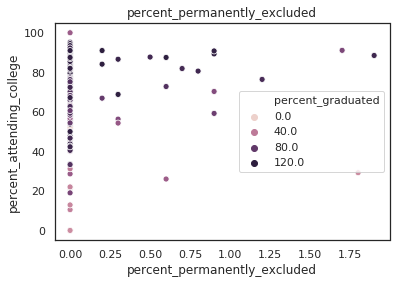

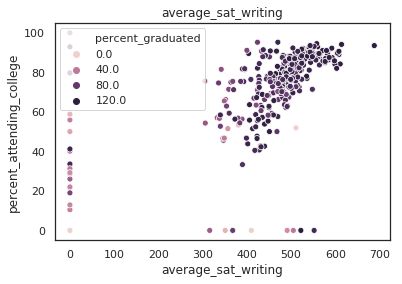

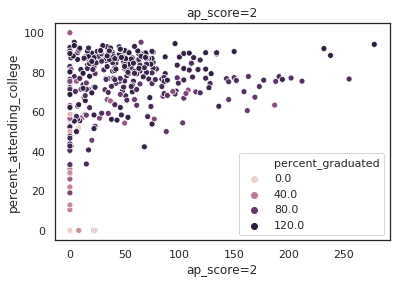

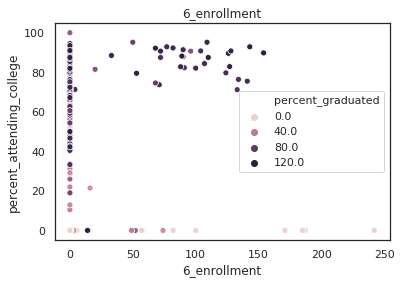

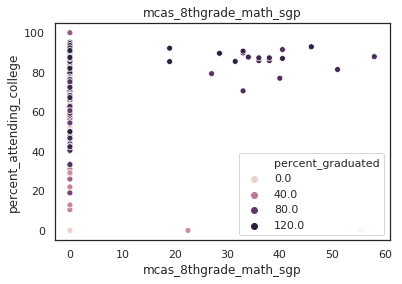

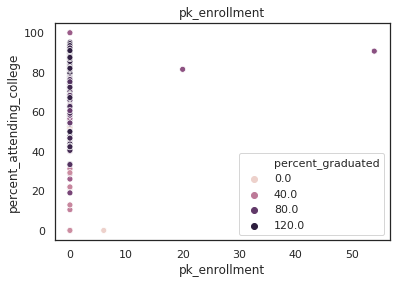

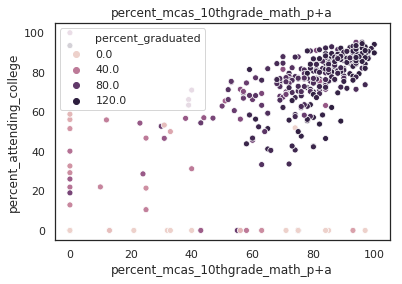

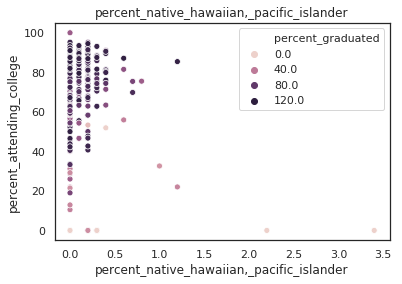

In [50]:
for col in X_lasso:
  plt.title(col)
  sns.scatterplot(x = col, y ='percent_attending_college',
                  data = mass_ed_high, hue = "percent_graduated" )
  plt.show()

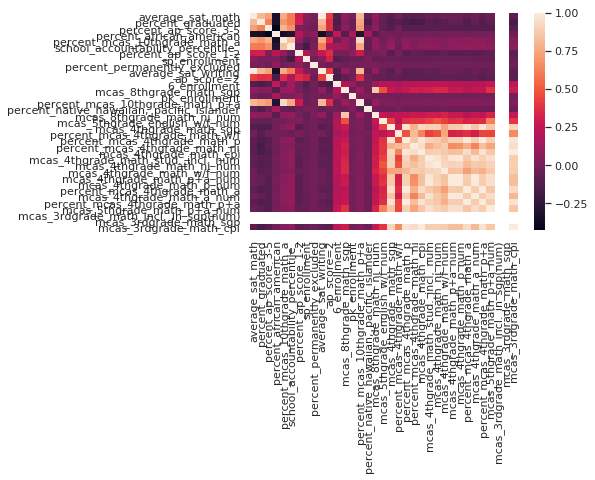

In [51]:
corr = X_lasso35.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)